In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

from dataset import *
from midi import *
from similarity import *

import util

In [2]:
generator = new_generator(root="../../dataset/newbie-dataset/", slice_duration=5, note_scale=1.00, mark_onset=True, shuffle=False)

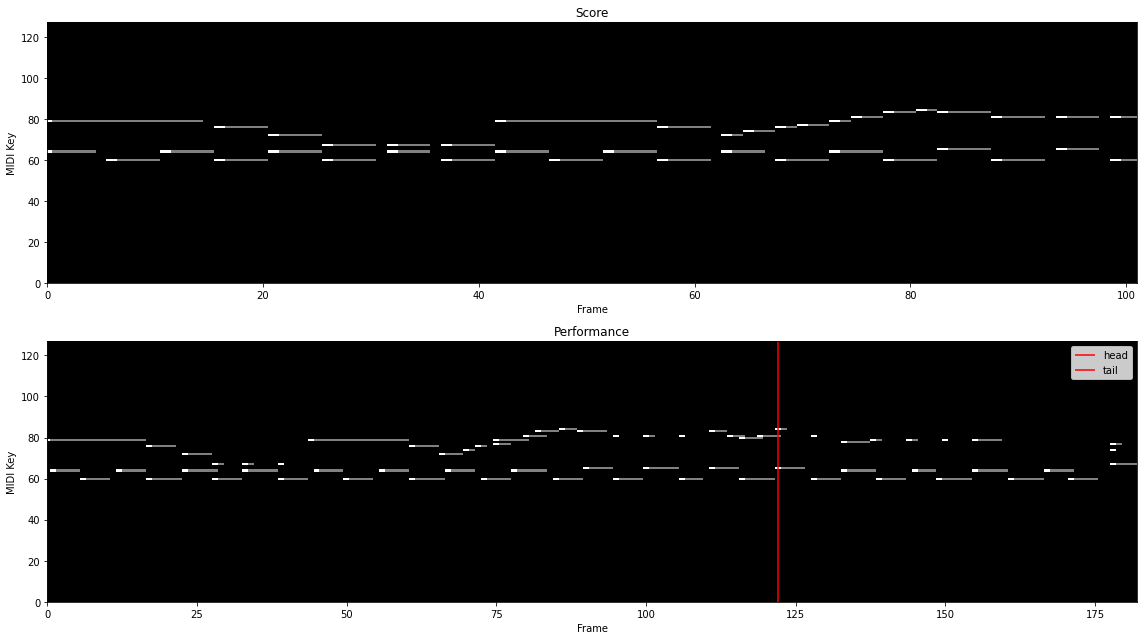

In [3]:
score_matrix, perf_matrix, (original_head, original_tail) = next(generator)
util.plot_midi_matrices(score_matrix, perf_matrix, (original_head, original_tail))

In [4]:
decay_fn = get_decay_fn("linear", settling_frame=10)
score_seq_list = MIDIUnitSequenceList.from_midi_matrix(score_matrix, decay_fn)
perf_seq_list = MIDIUnitSequenceList.from_midi_matrix(perf_matrix, decay_fn)

In [5]:
score_sequence = score_seq_list.repr_sequence
perf_sequence = perf_seq_list.repr_sequence
original_perf_sequence = perf_seq_list[original_head:original_tail+1].repr_sequence

In [6]:
original_cost, _, _, original_path = global_dtw(score_sequence, original_perf_sequence)
original_path = np.array(original_path)
print(f"{original_cost=:.2f}")

original_cost=0.50


In [7]:
global_cost, (global_head, global_tail), global_matrix, global_path = global_dtw(score_sequence, perf_sequence)
global_path = np.array(global_path)
print(f"{global_cost=:.2f}")

global_cost=0.83


In [8]:
subsequence_cost, (subsequence_head, subsequence_tail), subsequence_matrix, subsequence_path = subsequence_dtw(score_sequence, perf_sequence)
subsequence_path = np.array(subsequence_path)
print(f"{subsequence_cost=:.2f}")

subsequence_cost=0.40


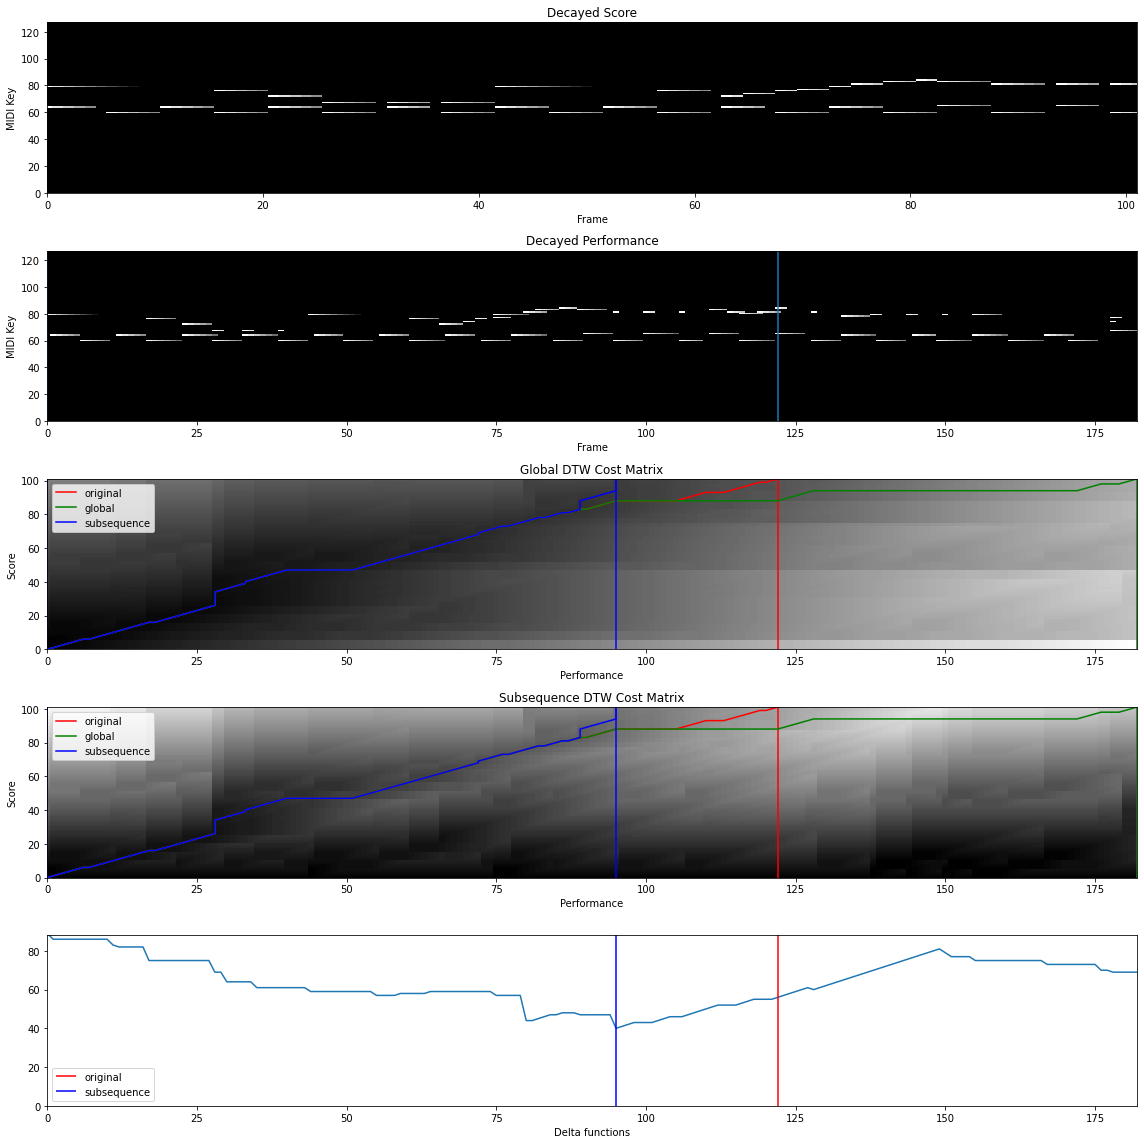

In [9]:
ymax, xmax = global_matrix.shape

plt.figure(figsize=(16, 16), facecolor="white")

plt.subplot(5, 1, 1)
plt.title("Decayed Score")
decayed_score_matrix = score_seq_list.to_midi_matrix(set_velocity=True)
plt.imshow(decayed_score_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.ylabel("MIDI Key")
plt.xlabel("Frame")
plt.ylim([0, 127])
plt.xlim([0, ymax-1])

plt.subplot(5, 1, 2)
plt.title("Decayed Performance")
decayed_perf_matrix = perf_seq_list.to_midi_matrix(set_velocity=True)
plt.imshow(decayed_perf_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.ylabel("MIDI Key")
plt.xlabel("Frame")
plt.vlines(original_head, 0, 127)
plt.vlines(original_tail, 0, 127)
plt.ylim([0, 127])
plt.xlim([0, xmax - 1])

plt.subplot(5, 1, 3)
plt.title("Global DTW Cost Matrix")
plt.imshow(global_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.vlines(original_head, 0, ymax, "r")
plt.vlines(original_tail, 0, ymax, "r")
plt.plot(original_path[:, 0], original_path[:, 1], "r", label="original")
plt.vlines(global_head, 0, ymax, "g")
plt.vlines(global_tail, 0, ymax, "g")
plt.plot(global_path[:, 0], global_path[:, 1], "g", label="global")
plt.vlines(subsequence_head, 0, ymax, "b")
plt.vlines(subsequence_tail, 0, ymax, "b")
plt.plot(subsequence_path[:, 0], subsequence_path[:, 1], "b", label="subsequence")
plt.ylim([0, ymax - 1])
plt.xlim([0, xmax - 1])
plt.xlabel("Performance")
plt.ylabel("Score")
plt.legend()

plt.subplot(5, 1, 4)
plt.title("Subsequence DTW Cost Matrix")
plt.imshow(subsequence_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.vlines(original_head, 0, ymax, "r")
plt.vlines(original_tail, 0, ymax, "r")
plt.plot(original_path[:, 0], original_path[:, 1], "r", label="original")
plt.vlines(global_head, 0, ymax, "g")
plt.vlines(global_tail, 0, ymax, "g")
plt.plot(global_path[:, 0], global_path[:, 1], "g", label="global")
plt.vlines(subsequence_head, 0, ymax, "b")
plt.vlines(subsequence_tail, 0, ymax, "b")
plt.plot(subsequence_path[:, 0], subsequence_path[:, 1], "b", label="subsequence")
plt.ylim([0, ymax - 1])
plt.xlim([0, xmax - 1])
plt.xlabel("Performance")
plt.ylabel("Score")
plt.legend()

plt.subplot(5, 1, 5)
delta_functions = subsequence_matrix[-1, :]
ymax = np.max(delta_functions)
plt.plot(np.arange(0, xmax), subsequence_matrix[-1, :])
plt.vlines(original_tail, 0, ymax, "r", label="original")
plt.vlines(subsequence_tail, 0, ymax, "b", label="subsequence")
plt.legend()
plt.xlim([0, xmax - 1])
plt.ylim([0, ymax - 1])
plt.xlabel("Delta functions")

plt.tight_layout()
plt.show()